In [122]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
import plotnine as pl

In [123]:
data = pd.read_csv("GPP_Merged_Data.csv")

C:\Users\tgbea\AppData\Local\Temp\ipykernel_15668\3109169440.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


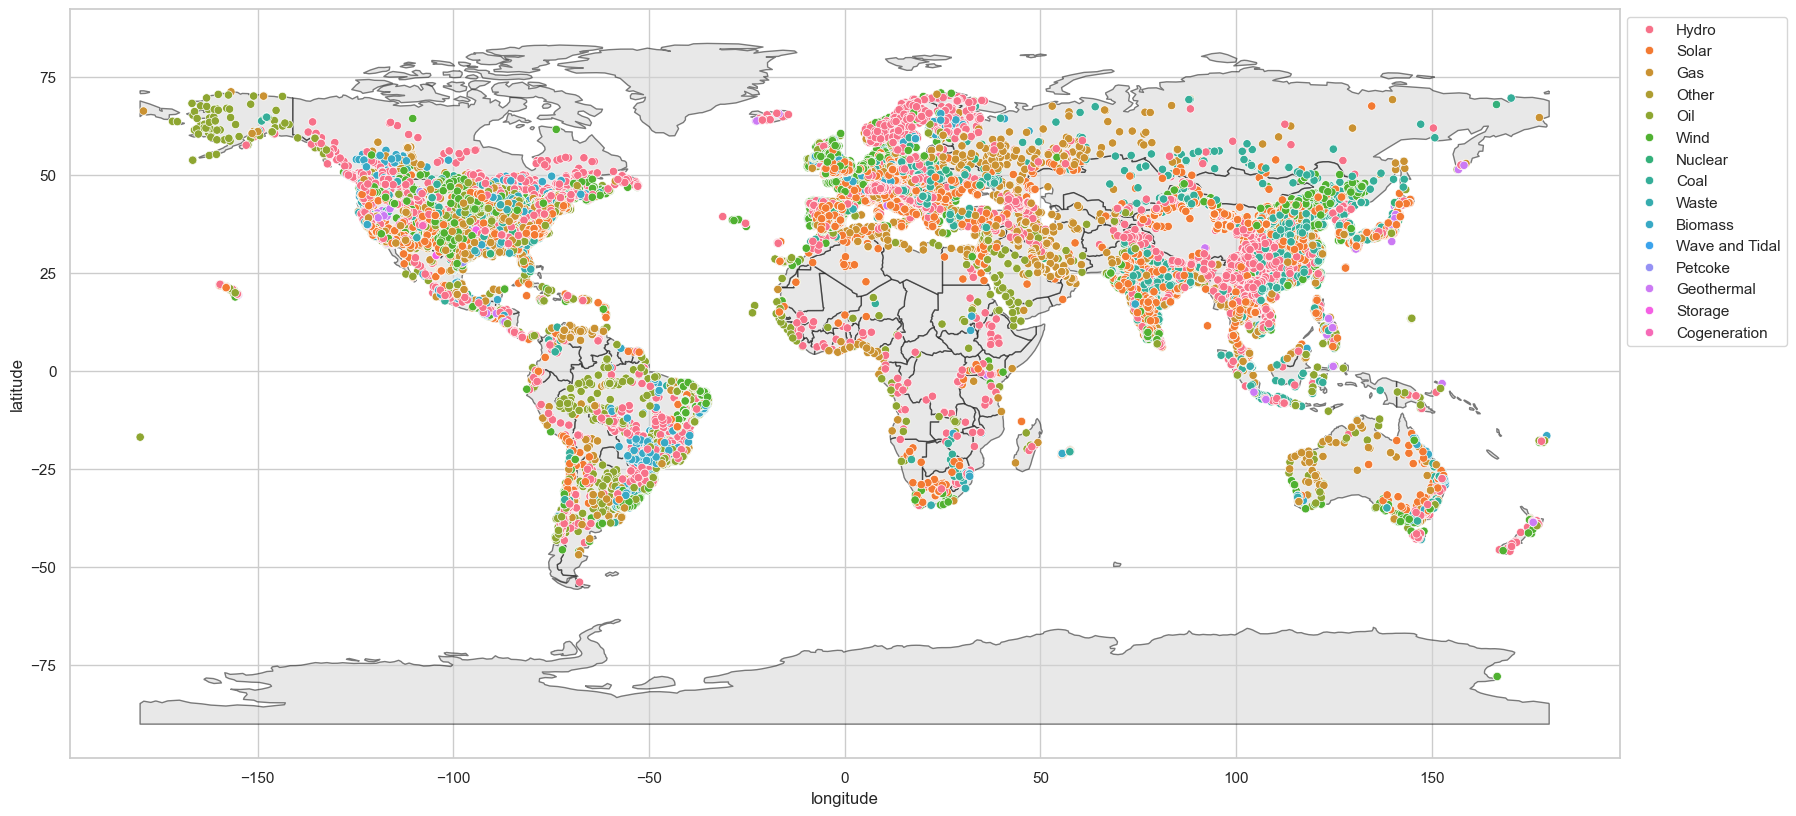

In [124]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
world.plot(
    ax=ax,
    color="lightgray",
    edgecolor="black",
    alpha=0.5
)
sns.scatterplot(data=data, y="latitude",x="longitude", hue="primary_fuel", legend="auto")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [125]:
set(data.primary_fuel)

{'Biomass',
 'Coal',
 'Cogeneration',
 'Gas',
 'Geothermal',
 'Hydro',
 'Nuclear',
 'Oil',
 'Other',
 'Petcoke',
 'Solar',
 'Storage',
 'Waste',
 'Wave and Tidal',
 'Wind'}

In [126]:
data.primary_fuel.value_counts()

primary_fuel
Solar             10665
Hydro              7156
Wind               5344
Gas                3998
Coal               2330
Oil                2320
Biomass            1430
Waste              1068
Nuclear             195
Geothermal          189
Storage             135
Other                43
Cogeneration         41
Petcoke              12
Wave and Tidal       10
Name: count, dtype: int64

## Generation capacity by country

In [127]:
capacities = {country : None for country in set(data["country"])}
for country in capacities.keys():
    swap = data["capacity_mw"].loc[data["country"] == country]
    population = data["Population"].loc[data["country"] == country]
    hdi = data["HDI"].loc[data["country"] == country]
    growth = data["Growth_rate_%"].loc[data["country"] == country]

    #note: growth rate is % 2013-2019
    capacities[country] = {"Capacity (MW)" : np.sum(swap), "Country" : country, "Population" : np.mean(population), 
                           "HDI": np.mean(hdi), "Growth Rate %": np.mean(growth)}

capacities = pd.DataFrame(capacities).T
capacities = capacities.sort_values(by="Capacity (MW)", ascending=False)
# capacities["Capacity (MW)"] = capacities["Capacity (MW)"].round(0)
capacities.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, CHN to LCA
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Capacity (MW)  167 non-null    object
 1   Country        167 non-null    object
 2   Population     162 non-null    object
 3   HDI            161 non-null    object
 4   Growth Rate %  140 non-null    object
dtypes: object(5)
memory usage: 7.8+ KB


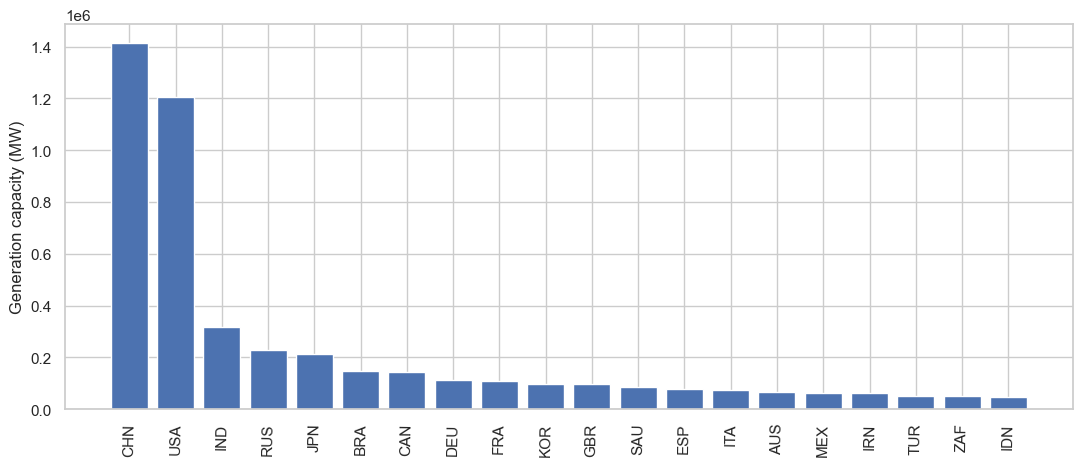

In [128]:
plt.figure(figsize=(13, 5))
plt.bar(capacities["Country"][:20], capacities["Capacity (MW)"][:20])
# plt.scatter(capacities["Country"][:20], capacities["HDI"][:20])
plt.xticks(rotation = 89)
plt.ylabel("Generation capacity (MW)")
plt.show()

In [129]:
for col in data:
    print(f"Column '\033[92m{col}\033[0m' has {np.sum(data[col].isna())} (\033[34m{np.sum(data[col].isna()) / len(data[col]):.2%}\033[0m) NA and {np.sum(data[col].isnull())} (\033[34m{np.sum(data[col].isnull()) / len(data[col]):.2%}\033[0m) missing values")

Column 'country' has 0 (0.00%) NA and 0 (0.00%) missing values
Column 'country_long' has 0 (0.00%) NA and 0 (0.00%) missing values
Column 'gppd_idnr' has 0 (0.00%) NA and 0 (0.00%) missing values
Column 'capacity_mw' has 0 (0.00%) NA and 0 (0.00%) missing values
Column 'latitude' has 0 (0.00%) NA and 0 (0.00%) missing values
Column 'longitude' has 0 (0.00%) NA and 0 (0.00%) missing values
Column 'primary_fuel' has 0 (0.00%) NA and 0 (0.00%) missing values
Column 'year_of_capacity_data' has 20049 (57.39%) NA and 20049 (57.39%) missing values
Column 'generation_gwh_2013' has 28519 (81.63%) NA and 28519 (81.63%) missing values
Column 'generation_gwh_2014' has 27710 (79.32%) NA and 27710 (79.32%) missing values
Column 'generation_gwh_2015' has 26733 (76.52%) NA and 26733 (76.52%) missing values
Column 'generation_gwh_2016' has 25792 (73.83%) NA and 25792 (73.83%) missing values
Column 'generation_gwh_2017' has 25436 (72.81%) NA and 25436 (72.81%) missing values
Column 'generation_gwh_2018'

## ggplot demo 

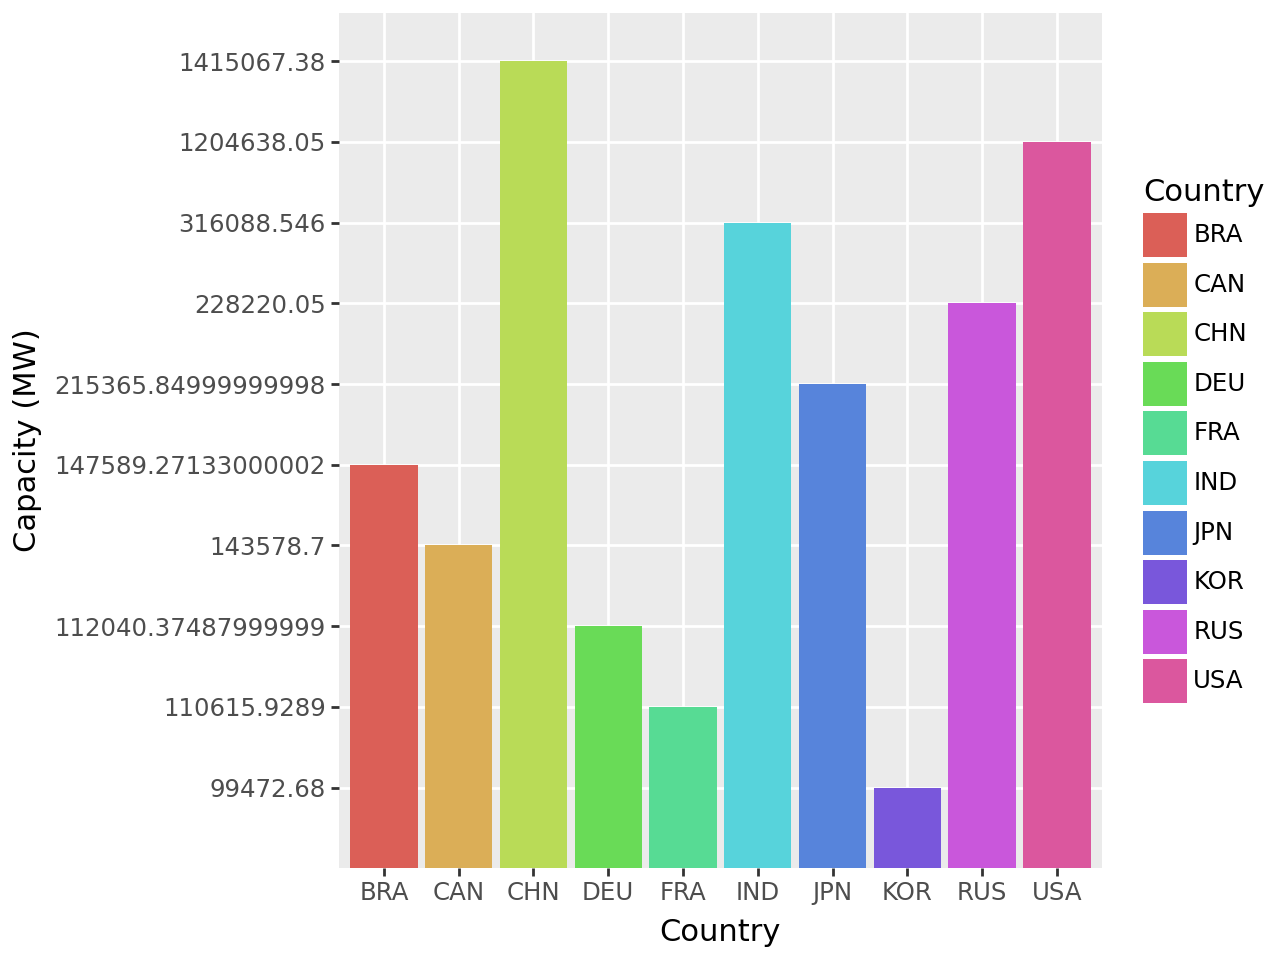

In [130]:
(
pl.ggplot(capacities.head(10)) +
    pl.aes(x="Country",y="Capacity (MW)",fill = "Country") +
    pl.geom_bar(stat="identity")
)

In [131]:
data["primary_fuel"].unique()

array(['Hydro', 'Solar', 'Gas', 'Other', 'Oil', 'Wind', 'Nuclear', 'Coal',
       'Waste', 'Biomass', 'Wave and Tidal', 'Petcoke', 'Geothermal',
       'Storage', 'Cogeneration'], dtype=object)

In [132]:
renewable_list = ('Hydro', 'Solar', 'Waste', 'Biomass', 'Wave and Tidal','Geothermal','Storage', 'Cogeneration','Wind')
# storage since I think it refers to pumped hydro and thermal solar storage

def is_renewable(x, ren):
    return True if x in ren else False

In [133]:
data["is_renewable"] = data["primary_fuel"].apply(is_renewable, ren = renewable_list)

<Axes: xlabel='Country'>

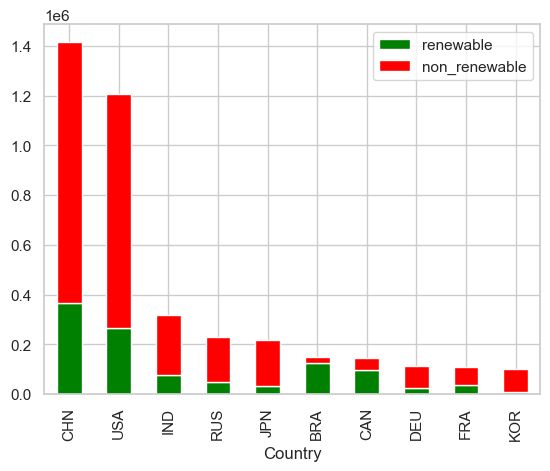

In [190]:
xtoplot_full = capacities["Country"]

data_splot_full =  pd.DataFrame(index = xtoplot_full, columns=['renewable', 'non_renewable'])

for country in xtoplot_full:
    temp = data[data["country"]==country]
    data_splot_full.loc[country, 'renewable'] = temp[temp["is_renewable"]]["capacity_mw"].sum()
    data_splot_full.loc[country, 'non_renewable'] = temp[~temp["is_renewable"]]["capacity_mw"].sum()
    data_splot_full.loc[country, 'country'] = country

sns.set(style="whitegrid")

xtoplot = xtoplot_full.iloc[:10]
data_splot = data_splot_full[:10]

data_splot.plot(kind = 'bar', stacked=True, color = ['green', 'red'])



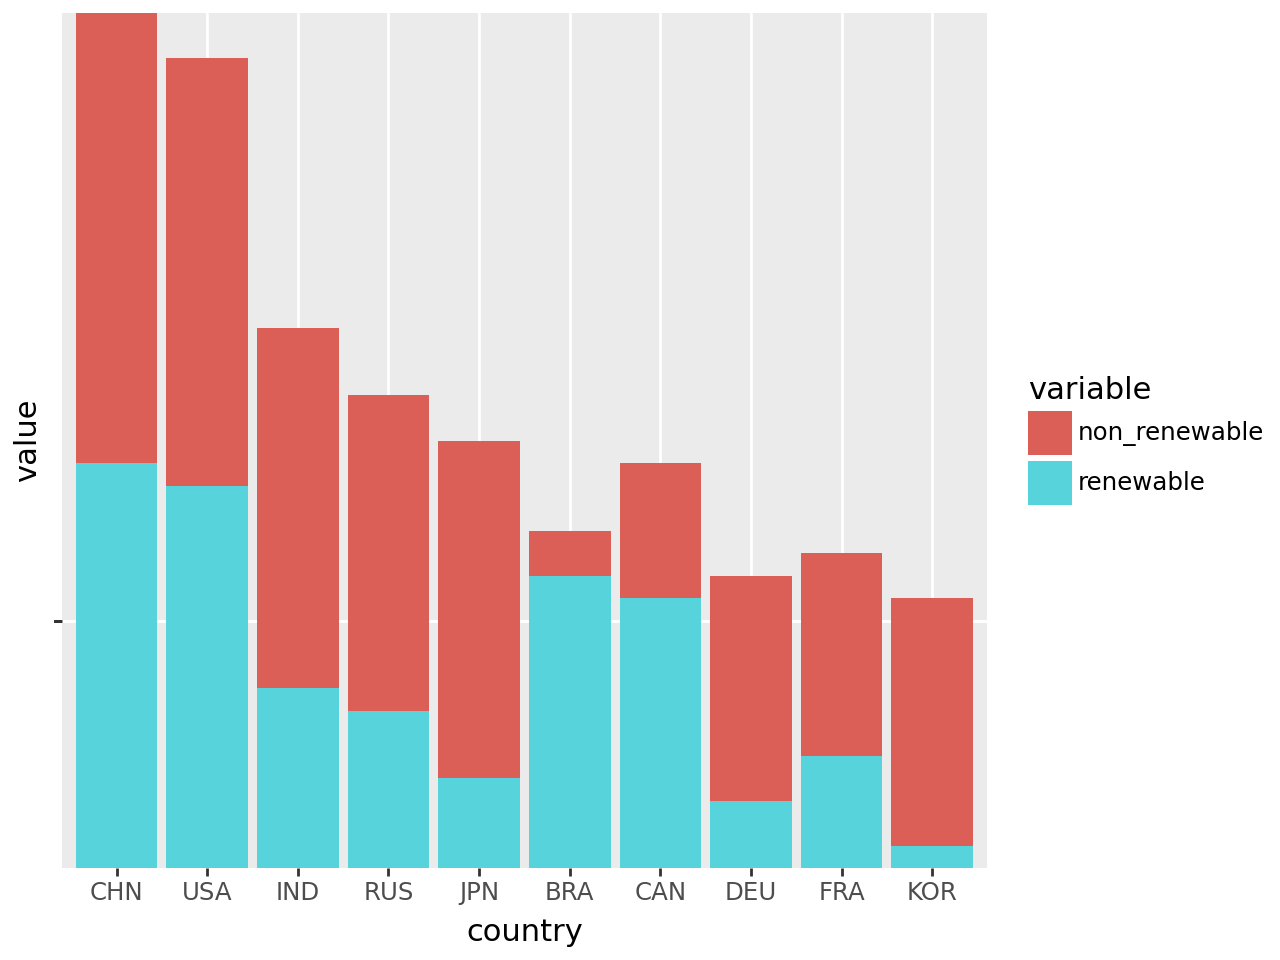

In [191]:
plot_df = pd.melt(data_splot, id_vars=["country"])
plot_df['country'] = pd.Categorical(plot_df['country'], categories=xtoplot)
plot_df['value'] = round(plot_df['value'], 0)

(pl.ggplot(plot_df, pl.aes("country", "value", fill = 'variable'))
 + pl.geom_col()
 + pl.scale_y_discrete(labels = [None for _ in range(len(set(plot_df["country"])))], breaks = [_ for _ in range(len(set(plot_df["country"])))])
 )

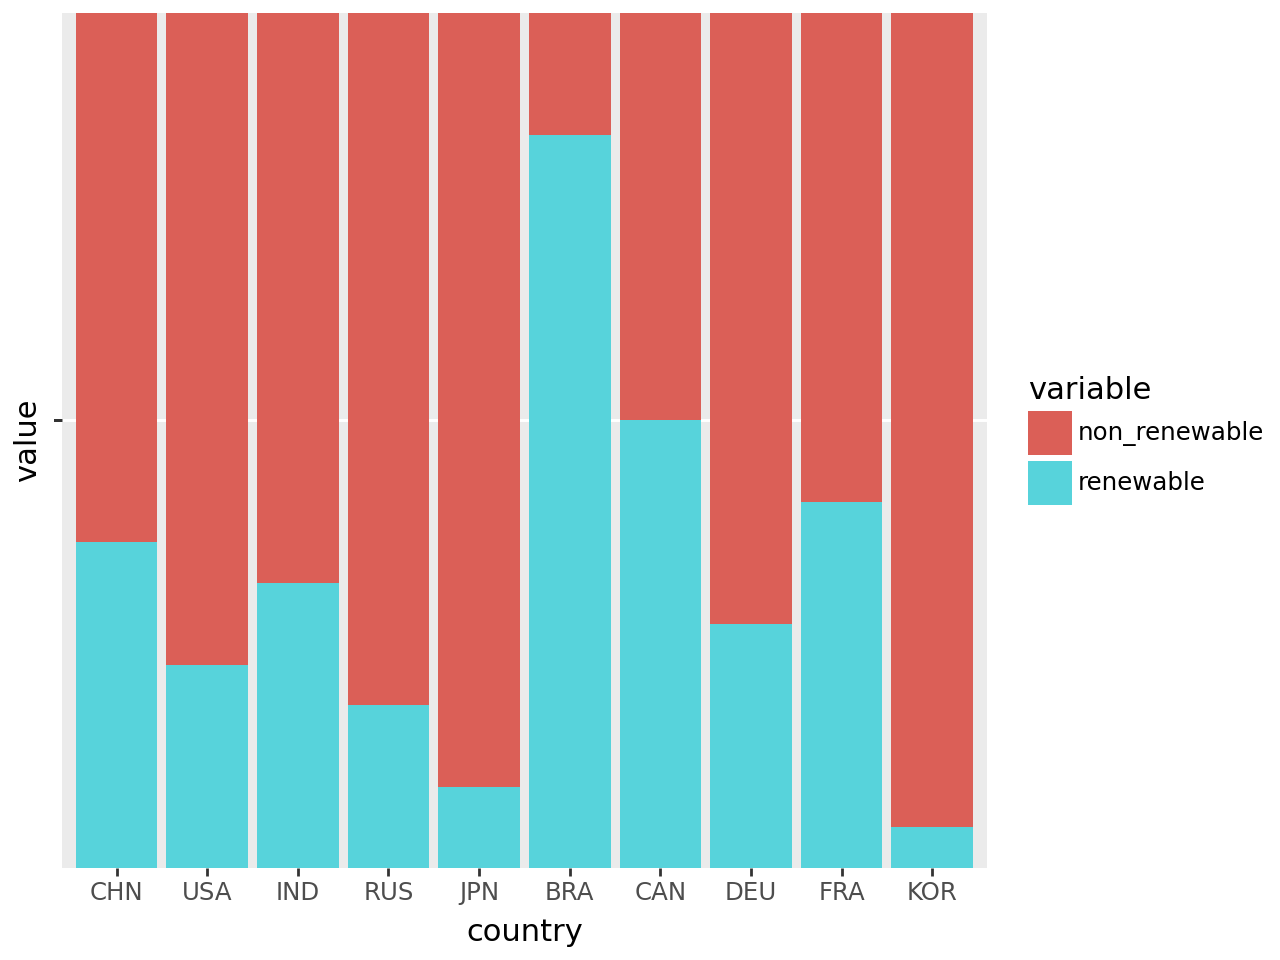

In [195]:
percent_data = data_splot_full.copy()
temp = percent_data["non_renewable"] + percent_data["renewable"]
percent_data["renewable"] /= temp
percent_data["non_renewable"] /= temp
percent_data.head()

percent_data_melt = percent_data[:10]
percent_data_melt = pd.melt(percent_data_melt, id_vars=["country"])
percent_data_melt['country'] = pd.Categorical(percent_data_melt['country'], categories=xtoplot)


(pl.ggplot(percent_data_melt, pl.aes("country", "value", fill = 'variable'))
 + pl.geom_col()
 + pl.scale_y_discrete(labels = [None for _ in range(len(set(plot_df["country"])))], breaks = [_ for _ in range(len(set(plot_df["country"])))])
 )

In [203]:
# sns.barplot()
countryHDI = capacities[["Country", "Capacity (MW)", "HDI", "Population", "Growth Rate %"]]
percent_data_hdi_full = pd.merge(percent_data, countryHDI, left_index=True, right_on='Country', how='inner')

percent_data_hdi_full.drop(['Country', 'country'], axis=1, inplace=True)
percent_data_hdi_full

,renewable,non_renewable,Capacity (MW),HDI,Population,Growth Rate %
CHN,0.257828,0.742172,1415067.38,0.749,1387067142.857143,-0.458927
USA,0.219769,0.780231,1204638.05,0.933,328329953.0,NaN
IND,0.239683,0.760317,316088.546,0.638,1383112050.0,-0.983095
RUS,0.206504,0.793496,228220.05,0.826429,144163826.857143,NaN
JPN,0.157095,0.842905,215365.85,0.913857,127050571.428571,0.091311
...,...,...,...,...,...,...
GNB,0.0,1.0,18.237,0.473714,1834253.0,-2.127998
PSE,1.0,0.0,7.6,0.715143,4370926.285714,NaN
ATA,0.131579,0.868421,7.6,NaN,NaN,NaN
SUR,1.0,0.0,5.0,0.707286,581733.142857,-0.892442


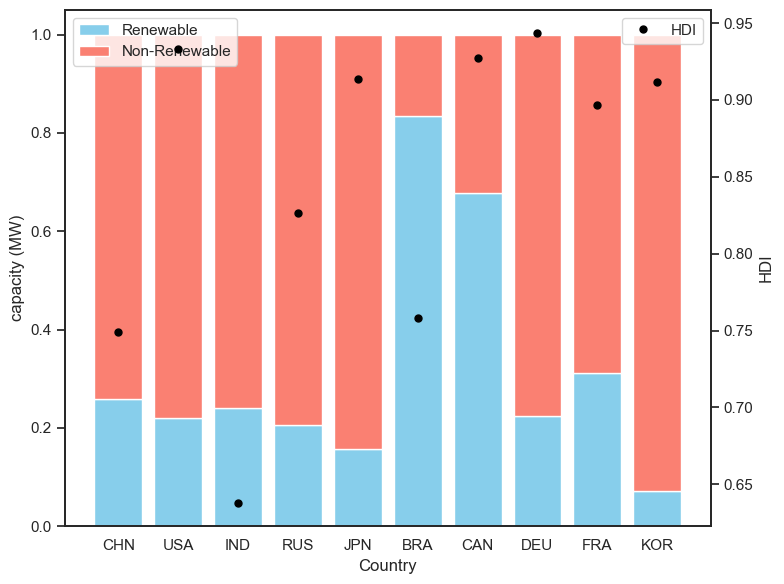

In [204]:
pastel_palette = sns.color_palette("pastel")

percent_data_hdi = percent_data_hdi_full[:10]
# Extract data for plotting
sns.set_style('white')
# sns.set_color_codes()
countries = percent_data_hdi.index
renewable = percent_data_hdi['renewable']
non_renewable = percent_data_hdi['non_renewable']
hdi = percent_data_hdi['HDI']

# Create stacked bar chart
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.bar(countries, renewable, label='Renewable', color='skyblue')
ax1.bar(countries, non_renewable, bottom=renewable, label='Non-Renewable', color='salmon')

# Overlay HDI as points
ax2 = ax1.twinx()
ax2.plot(countries, hdi, marker='o', linestyle='', markersize=5, label='HDI', color='black')

# Set labels and legend
ax1.set_xlabel('Country')
ax1.set_ylabel('capacity (MW)')
ax2.set_ylabel('HDI')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show plot
plt.tight_layout()
plt.show()


In [165]:
pastel_palette = sns.color_palette("pastel")

pastel_palette


[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

,Capacity (MW),Country,Population,HDI,Growth Rate %
CHN,1415067.38,CHN,1387067142.857143,0.749,-0.458927
USA,1204638.05,USA,328329953.0,0.933,NaN
IND,316088.546,IND,1383112050.0,0.638,-0.983095
RUS,228220.05,RUS,144163826.857143,0.826429,NaN
JPN,215365.85,JPN,127050571.428571,0.913857,0.091311


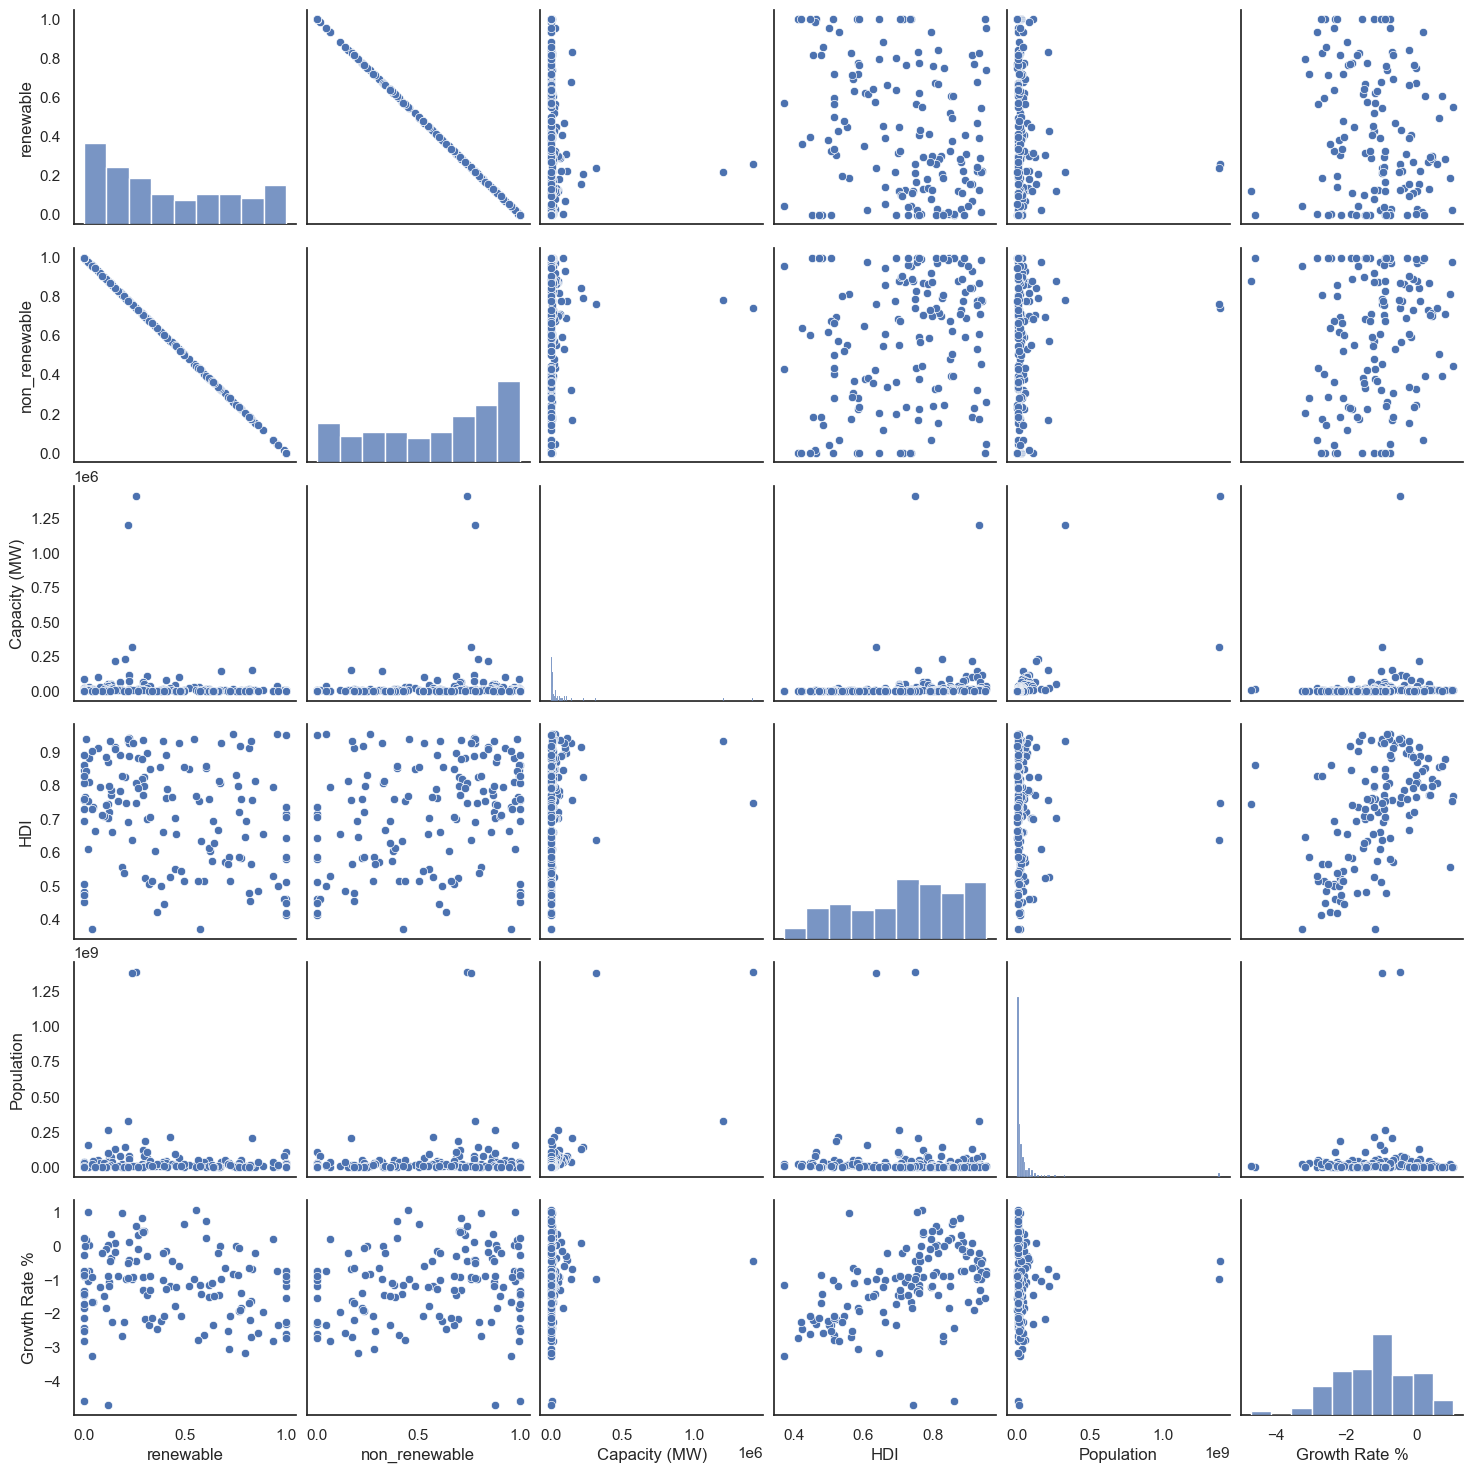

In [205]:
# sns.set_style('whitegrid')
# sns.PairGrid(capacities).map(plt.scatter)
sns.pairplot(percent_data_hdi_full)
# plt.show()
# capacities.head()

In [206]:
percent_data_hdi_full

,renewable,non_renewable,Capacity (MW),HDI,Population,Growth Rate %
CHN,0.257828,0.742172,1415067.38,0.749,1387067142.857143,-0.458927
USA,0.219769,0.780231,1204638.05,0.933,328329953.0,NaN
IND,0.239683,0.760317,316088.546,0.638,1383112050.0,-0.983095
RUS,0.206504,0.793496,228220.05,0.826429,144163826.857143,NaN
JPN,0.157095,0.842905,215365.85,0.913857,127050571.428571,0.091311
...,...,...,...,...,...,...
GNB,0.0,1.0,18.237,0.473714,1834253.0,-2.127998
PSE,1.0,0.0,7.6,0.715143,4370926.285714,NaN
ATA,0.131579,0.868421,7.6,NaN,NaN,NaN
SUR,1.0,0.0,5.0,0.707286,581733.142857,-0.892442
